In [1]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores, get_filtered_scores
from NN import NN
from CNN import CNN
import similarities 
import DShap

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
noise_idx = load_tabular_data('blog', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
not_noise_idx = np.delete(np.arange(1000), noise_idx)
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

In [3]:
x_train.shape

(1000, 280)

In [31]:
model = NN(in_channels=280, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))
dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)

CEL = torch.nn.CrossEntropyLoss() 
print()

tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), 
                                similarity     = similarities.cosine_similarity(), 
                                optim          = torch.optim.Adam, 
                                lr             = 1e-3, 
                                num_epochs     = 100, 
                                compute_every  = 1, 
                                batch_size     = 200, 
                                num_workers    = 1, 
                                grad_params    = None, 
                                verbose        = True, 
                                use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')


using device: cuda
epoch 99 || avg loss: 0.38 || grad time elapsed: 0.1 s0.0311s/batch)
time elapsed: 0.44 min


In [33]:
pred = NN(in_channels=280, out_channels=2, num_layers=2, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
est = NN(in_channels=284, out_channels=1, num_layers=2, hidden_channels=400, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())

dvrl = DVRL(train_dataset, valid_dataset, test_dataset, predictor=pred, estimator=est, problem='classification')
CEL = torch.nn.CrossEntropyLoss() 
print()

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), 
                     outer_iter             = 2000, 
                     inner_iter             = 100, 
                     outer_batch            = 2000, 
                     outer_workers          = 1, 
                     inner_batch            = 256, 
                     estim_lr               = 1e-2, 
                     pred_lr                = 1e-3, 
                     moving_average_window  = 20,
                     entropy_beta           = 0.01, 
                     entropy_decay          = 0.999,
                     fix_baseline           = False)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      


pretraining `ori_model` and `val_model` 
outer iteration: 1999 || reward: 0.0356 || dvrl perf: 0.7132 || baseline: 0.6794 || log entropy beta: -2.8690 || epoch elapsed: 0.6 ssss
time elapsed: 26.51 min


In [6]:
model = NN(in_channels=280, out_channels=2, num_layers=1, hidden_channels=50, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = model.cpu(), 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    train_dataset   = copy.deepcopy(train_dataset), 
                    V               = DShap.V(copy.deepcopy(valid_dataset), roc_auc_score),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3)

tic = time.time() 
vals_shap = dshap.TMC(max_iterations=250, min_iterations=100, use_cuda=True, T=5, stopping_criteria=0.999)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

v0: 0.4832
vD: 0.6577

iter: 139 || max j: 725 || max vj: 0.6470 || rank_corr: 0.9989
MC stopping criteria met. running avg rank correlation: 0.9990

time elapsed: 207.08 min


In [7]:
dvgs_data_values = vals_dvgs.mean(axis=1)
dvrl_data_values = vals_dvrl.detach().cpu().numpy().ravel() 
shap_data_values = vals_shap.ravel()

pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(dvgs_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(dvrl_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, shap_corr, p_perfect, p_random = get_corruption_scores(shap_data_values, noise_idx, train_size=1000, noise_prop=0.2)

(1000,)
(1000,)
(1000,)


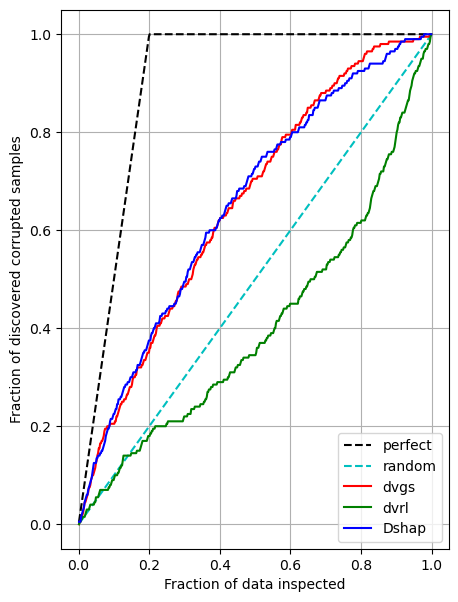

In [34]:
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.plot(pk, dvrl_corr, 'g-', label='dvrl')
plt.plot(pk, shap_corr, 'b-', label='Dshap')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [37]:
model = NN(in_channels=280, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.05, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long))
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1]) 

rand_data_values = np.random.normal(0,1,size=dvgs_data_values.shape)

qs = np.linspace(0., 0.5, 5)
bs = 256 
nw = 1 
lr = 1e-3 
ep = 100
rp = 3

dvgs_low, dvgs_high = get_filtered_scores(dvgs_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
dvrl_low, dvrl_high = get_filtered_scores(dvrl_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
shap_low, shap_high = get_filtered_scores(shap_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)
rand_low, rand_high = get_filtered_scores(rand_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, num_workers=nw, lr=lr, epochs=ep, repl=rp)


training filtered models... progress: 4/5
training filtered models... progress: 4/5
training filtered models... progress: 4/5
training filtered models... progress: 4/5


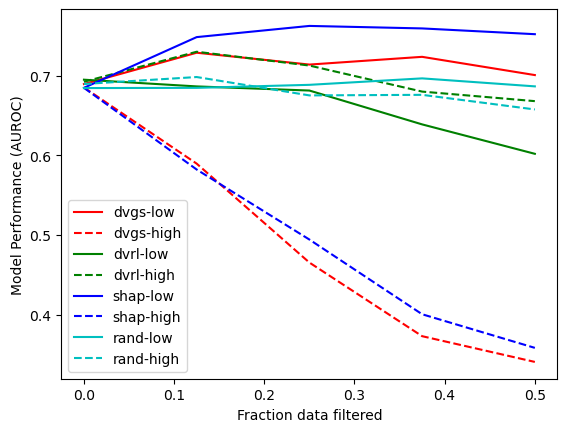

In [40]:
plt.figure()
plt.plot(qs, dvgs_low, 'r-', label='dvgs-low')
plt.plot(qs, dvgs_high, 'r--', label='dvgs-high')

plt.plot(qs, dvrl_low, 'g-', label='dvrl-low')
plt.plot(qs, dvrl_high, 'g--', label='dvrl-high')

plt.plot(qs, shap_low, 'b-', label='shap-low')
plt.plot(qs, shap_high, 'b--', label='shap-high')

plt.plot(qs, rand_low, 'c-', label='rand-low')
plt.plot(qs, rand_high, 'c--', label='rand-high')

plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.legend() 
plt.show()